### Tutorial: Sensing Cox Process II
Defining kernels, and plotting maps

#### Fitting the Cox Process

In [1]:
%pip install contextily

Note: you may need to restart the kernel to use updated packages.


In [4]:
from stpy.kernels import KernelFunction
from stpy.borel_set import BorelSet,HierarchicalBorelSets
from stpy.point_processes.poisson_rate_estimator import PoissonRateEstimator
import torch 
import pandas as pd
import geopandas
import numpy as np 
import matplotlib.pyplot as plt
import contextily as ctx
from scipy.interpolate import griddata
from stpy.point_processes.poisson.poisson import PoissonPointProcess
from sensepy.capture_thompson import CaptureThompson

2024-10-11 13:36:35.523652: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-11 13:36:35.539738: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-11 13:36:35.544252: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-11 13:36:35.555842: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-11 13:36:36.963044: W tensorflow/compiler/tf2

In [6]:
## Demonstration of fitting a Cox Process

# lenghtscale of squared exponential kernel
gamma = 0.12

# borel set a square with boundaries [-1,1]^2
D = BorelSet(2, bounds=torch.Tensor([[-1., 1.], [-1, 1]]).double())

# quadtree with [-1,1], levels signifies number of splits
hs2d = HierarchicalBorelSets(d=2, interval=[(-1, 1), (-1, 1)], levels=5)

# kernel function
k = KernelFunction(kernel_name = "squared_exponential", gamma=gamma, d=2)

# creating estimator - the first argument is Poisson process object if existing
m = 10  # number of basis functions 
b = 0.1 # minimal value of the rate function 
B = 10e10 # maximal value of the rate function
steps = 200 # number of Langevin steps for sampling
estimator = PoissonRateEstimator(
    hs2d,
    d=2,
    kernel=k,
    max_intensity=B,
    min_intensity=b,
    basis_size_per_dim=m,
    jitter=10e-3,
    langevine_sampling_steps=steps,
)

Precomputing phis.
Precomputation finished.


In [7]:
# loading data 
N = 2000
name = '../benchmarks/data/taxi_data.csv'
df = pd.read_csv(name)
df = df.head(N)
df = df[df['Longitude'] < -8.580]
df = df[df['Longitude'] > -8.64]
df = df[df['Latitude'] > 41.136]
df = df[df['Latitude'] < 41.17]

gdf = geopandas.GeoDataFrame(df, geometry=geopandas.points_from_xy(df.Longitude,df.Latitude))
gdf.crs = "EPSG:4326"

# cleaning nans
obs = df.values[:, [1,2]].astype(float)
obs = obs[~np.isnan(obs)[:, 0], :]

x_max = np.max(obs[:, 0]) # longitude
x_min = np.min(obs[:, 0])

y_max = np.max(obs[:, 1]) # lattitude
y_min = np.min(obs[:, 1])
lat = df['Latitude']
long = df['Longitude']

left, right = long.min(),long.max()
down, up =   lat.min(), lat.max()

# transform from map to [-1,1]
transform_x = lambda x: (2 / (x_max - x_min)) * x + (1 - (2 * x_max / (x_max - x_min)))
transform_y = lambda y: (2 / (y_max - y_min)) * y + (1 - (2 * y_max / (y_max - y_min)))

# transform from [-1,1] to map
inv_transform_x = lambda x: (x_max - x_min) / 2 * x + (x_min + x_max) / 2
inv_transform_y = lambda x: (y_max - y_min) / 2 * x + (y_min + y_max) / 2

# transform to [-1,1]
obs[:, 0] = np.apply_along_axis(transform_x, 0, obs[:, 0])
obs[:, 1] = np.apply_along_axis(transform_y, 0, obs[:, 1])

# extract temporal information of the dataset
df['Date']= pd.to_datetime(df['Date'])
# time section of the dataset in minutes
dt = (df['Date'].max() - df['Date'].min()).seconds//60
data = [(D, torch.from_numpy(obs), dt)]

In [8]:
# load data in the above format
estimator.load_data(data)
# fit the Cox process by calculating MAP
estimator.fit_gp()

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH


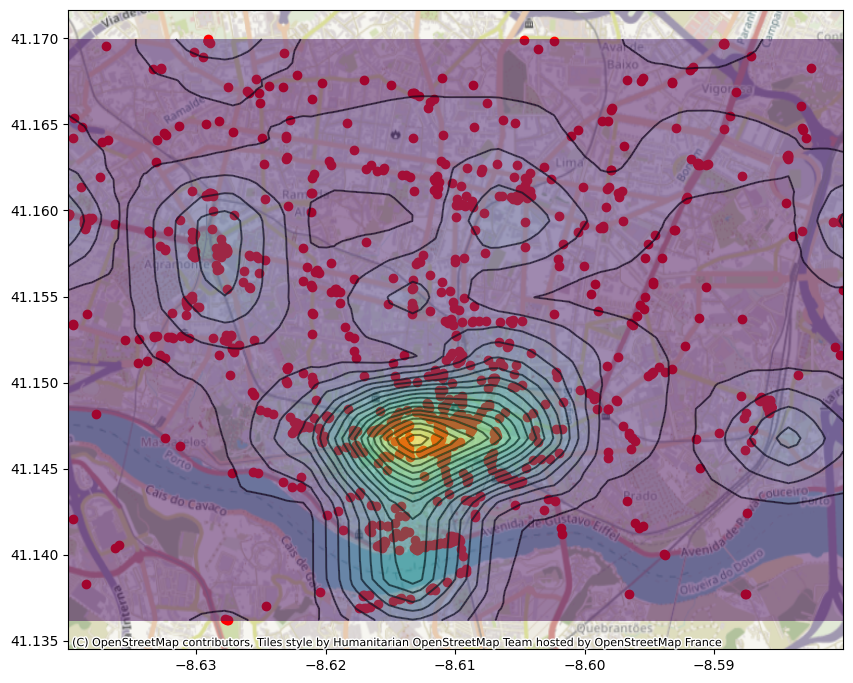

In [9]:
# Plotting the fitted Map 
n = 30 # discretization
xtest = D.return_discretization(n)
Map = BorelSet(d=2, bounds=torch.Tensor([[left, right], [down, up]]).double())
xtest_orig = Map.return_discretization(n).numpy()

f = estimator.rate_value(xtest)

xx = xtest_orig[:, 0]
yy = xtest_orig[:, 1]

grid_x, grid_y = np.mgrid[min(xx):max(xx):100j, min(yy):max(yy):100j]
grid_z_f = griddata((xx, yy), f[:, 0].detach().numpy(), (grid_x, grid_y), method='linear')

fig, ax = plt.subplots(figsize=(10, 10))
gdf.plot(ax=ax, color='red', figsize=(10, 10))
cs = ax.contourf(grid_x, grid_y, grid_z_f, levels=20, alpha=0.5)
ax.contour(cs, colors='k', alpha=0.5)
ctx.add_basemap(ax, crs=gdf.crs.to_string())
plt.show()